<center>

## **Lab 2**

# **Classification**

</center>

### **Student information**

**Student's name**: Nguyễn Công Tuấn

**Student's ID**: 22127436

**Class** 22KHDL1

### **Self-evaluation of the assignment requirements**

<center>

| **No.** | **Details** | **Evaluation** |
| --- | --- | --- |
| 1 | Data Cleaning | 100% | 
| 2 | Features Selection | 100% |
| 3 | Data Normalization | 100% |
| 4 | Data Discretization | 100% |
| 5 | Detailed explanation of each step. Illustrative images, diagrams and equations are required | 100% |
| 6 | Each processing step must be fully commented, and results should be printed for observation | 100% |
| 7 | The report needs to be well-formatted | 100% |
| 8 | Before submitting, re-run the notebook (Kernel → Restart & Run All) | 100% |
| 9 | Reference (if any) | 100% |

</center>

In [ ]:
# %pip install ucimlrepo 

In [31]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

In [2]:
adult = fetch_ucirepo(id=2) 

In [3]:
X = adult.data.features 
y = adult.data.targets 
  
adult.variables

,name,role,type,demographic,description,units,missing_values
0,age,Feature,Integer,Age,N/A,None,no
1,workclass,Feature,Categorical,Income,"Private, Self-emp-not-inc, Self-emp-inc, Feder...",None,yes
2,fnlwgt,Feature,Integer,None,None,None,no
3,education,Feature,Categorical,Education Level,"Bachelors, Some-college, 11th, HS-grad, Prof-...",None,no
4,education-num,Feature,Integer,Education Level,None,None,no
5,marital-status,Feature,Categorical,Other,"Married-civ-spouse, Divorced, Never-married, S...",None,no
6,occupation,Feature,Categorical,Other,"Tech-support, Craft-repair, Other-service, Sal...",None,yes
7,relationship,Feature,Categorical,Other,"Wife, Own-child, Husband, Not-in-family, Other...",None,no
8,race,Feature,Categorical,Race,"White, Asian-Pac-Islander, Amer-Indian-Eskimo,...",None,no
9,sex,Feature,Binary,Sex,"Female, Male.",None,no


In [4]:
X = pd.concat([X, y], axis=1)

X.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


# **Data Cleaning**

In [5]:
X = X.replace('?', np.nan) # replace '?' with NaN

missing_data = X.isna().sum()
print("Missing data per column:\n", missing_data)

Missing data per column:
 age                  0
workclass         2799
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        2809
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     857
income               0
dtype: int64


In [6]:
X = X.fillna({"workclass": "Unknown", "occupation": "Unknown", "native-country": "Unknown"})

**Identification of Duplicate Records**

In [7]:
X = X.drop_duplicates(keep="first")

**Additional Data Cleaning Methods**

In [8]:
X = X.apply(lambda col: col.str.lower() if col.dtype == 'object' else col)

In [9]:
X['income'] = X['income'].replace({'>50k.': '>50k', '<=50k.': '<=50k'})

In [10]:
X['income'] = X['income'].map({'<=50k': 0, '>50k': 1})

# **Features Selection**

In [11]:
X_encoded = X.copy()

categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.drop("income")

for col in categorical_cols:
    X_encoded[col] = X_encoded[col].astype('category').cat.codes

# Step 1: Apply log transformation to capital-gain and capital-loss
X_encoded["capital-gain"] = np.log1p(X_encoded["capital-gain"])
X_encoded["capital-loss"] = np.log1p(X_encoded["capital-loss"])

# Step 2: Discretize / Binning numerical variables
for col in numerical_cols:
    if col in ["capital-gain", "capital-loss"]:
        # Compute unique bin edges to avoid duplicates
        bin_edges = sorted(set([-1, 0, 
                                X_encoded[col].quantile(0.25), 
                                X_encoded[col].quantile(0.5), 
                                X_encoded[col].quantile(0.75), 
                                X_encoded[col].max()]))

        X_encoded[col] = pd.cut(X_encoded[col], bins=bin_edges, labels=False, duplicates='drop')
    else:
        X_encoded[col] = pd.qcut(X_encoded[col], q=10, duplicates='drop', labels=False)

# Compute Mutual Information
def mutual_info(target, features):
    mi_scores = {}

    for col in features:
        joint = pd.crosstab(X_encoded[col], X_encoded[target])
        total = joint.values.sum()

        prob_x = joint.sum(axis=1).values / total  
        prob_y = joint.sum(axis=0).values / total  
        prob_xy = joint / total  

        mi = np.nansum(prob_xy * np.log2(prob_xy / (prob_x[:, np.newaxis] * prob_y ) + 1e-10))
        mi_scores[col] = mi

    return mi_scores

mi_scores = mutual_info("income", X_encoded.columns.drop("income"))

mi_df = pd.DataFrame(list(mi_scores.items()), columns=["Feature", "Mutual Information"])
mi_df = mi_df.sort_values(by="Mutual Information", ascending=False)

print("Mutual Information Scores:")
print(mi_df.to_string(index=False))


Mutual Information Scores:
       Feature  Mutual Information
  relationship            0.165409
marital-status            0.156963
           age            0.093383
     education            0.092127
    occupation            0.091894
 education-num            0.087221
hours-per-week            0.055459
  capital-gain            0.042762
           sex            0.036695
     workclass            0.022300
  capital-loss            0.011425
          race            0.008200
native-country            0.008165
        fnlwgt            0.000733


In [12]:
X = X.drop(columns=["fnlwgt", "race", "native-country"])

In [13]:
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

X_encoded = X.copy()
for col in categorical_cols:
    X_encoded[col] = X_encoded[col].astype('category').cat.codes

# Function to compute Cramér's V manually (for categorical features)
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y).values 
    chi2 = np.sum((confusion_matrix - confusion_matrix.sum(axis=1, keepdims=True) * 
                   confusion_matrix.sum(axis=0, keepdims=True) / confusion_matrix.sum())**2 /
                   (confusion_matrix.sum(axis=1, keepdims=True) * confusion_matrix.sum(axis=0, keepdims=True) / confusion_matrix.sum()))
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(r - 1, k - 1)) if min(r - 1, k - 1) > 0 else 0  

# Compute Pearson correlation for numerical features
numerical_corr = X_encoded[numerical_cols].corr()

# Compute Cramér’s V for categorical features
cramers_v_matrix = pd.DataFrame(index=categorical_cols, columns=categorical_cols)

for col1 in categorical_cols:
    for col2 in categorical_cols:
        if col1 == col2:
            cramers_v_matrix.loc[col1, col2] = 1.0 
        else:
            cramers_v_matrix.loc[col1, col2] = cramers_v(X_encoded[col1], X_encoded[col2])

# Convert to numeric type
cramers_v_matrix = cramers_v_matrix.astype(float)


full_corr_matrix = pd.DataFrame(index=X_encoded.columns, columns=X_encoded.columns, dtype=float)

# Fill numerical correlation values
for col1 in numerical_cols:
    for col2 in numerical_cols:
        full_corr_matrix.loc[col1, col2] = numerical_corr.loc[col1, col2]

# Fill Cramér's V values for categorical features
for col1 in categorical_cols:
    for col2 in categorical_cols:
        full_corr_matrix.loc[col1, col2] = cramers_v_matrix.loc[col1, col2]

# Fill correlations between categorical & numerical using Pearson (since numeric encoding is used)
for col1 in categorical_cols:
    for col2 in numerical_cols:
        full_corr_matrix.loc[col1, col2] = X_encoded[col1].corr(X_encoded[col2])
        full_corr_matrix.loc[col2, col1] = full_corr_matrix.loc[col1, col2] 

print("Full Correlation Matrix (Numerical: Pearson, Categorical: Cramér's V):")
print(full_corr_matrix)

Full Correlation Matrix (Numerical: Pearson, Categorical: Cramér's V):
                     age  workclass  education  education-num  marital-status  \
age             1.000000   0.052968  -0.015176       0.030760       -0.263866   
workclass       0.052968   1.000000   0.100016      -0.045938        0.085458   
education      -0.015176   0.100016   1.000000       0.359652        0.090958   
education-num   0.030760  -0.045938   0.359652       1.000000       -0.069911   
marital-status -0.263866   0.085458   0.090958      -0.069911        1.000000   
occupation      0.006754   0.400082   0.186593       0.045096        0.131642   
relationship   -0.263416   0.100813   0.122585      -0.090672        0.488163   
sex             0.088073   0.151771   0.093309       0.009284        0.459477   
capital-gain    0.077221   0.012044   0.028944       0.125186       -0.043954   
capital-loss    0.056908  -0.004671   0.017654       0.080969       -0.033840   
hours-per-week  0.071322  -0.078086   

In [14]:
X = X.drop(columns=["workclass", "education", "sex", "relationship"])

# **Data Normalization**

In [15]:
def min_max_scaling(column, new_min=0, new_max=1):
    X_min = column.min()
    X_max = column.max()
    return (column - X_min) / (X_max - X_min) * (new_max - new_min) + new_min

X["age"] = min_max_scaling(X["age"])

In [16]:
def decimal_scaling(column):
    j = np.ceil(np.log10(column.abs().max()))  # Compute scaling factor
    return column / (10 ** j)

X["capital-gain"] = decimal_scaling(X["capital-gain"])
X["capital-loss"] = decimal_scaling(X["capital-loss"])

In [17]:
def z_score_standardization(column):
    return (column - column.mean()) / column.std()

X["education-num"] = z_score_standardization(X["education-num"])
X["hours-per-week"] = z_score_standardization(X["hours-per-week"])

In [18]:
X = pd.get_dummies(X, columns=['marital-status', 'occupation'], drop_first=True)

# **Classification algorithm implementation**

In [19]:
X

,age,education-num,capital-gain,capital-loss,hours-per-week,income,marital-status_married-af-spouse,marital-status_married-civ-spouse,marital-status_married-spouse-absent,marital-status_never-married,...,occupation_handlers-cleaners,occupation_machine-op-inspct,occupation_other-service,occupation_priv-house-serv,occupation_prof-specialty,occupation_protective-serv,occupation_sales,occupation_tech-support,occupation_transport-moving,occupation_unknown
0,0.301370,1.136584,0.02174,0.0,-0.034303,0,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
1,0.452055,1.136584,0.00000,0.0,-2.213312,0,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,0.287671,-0.419681,0.00000,0.0,-0.034303,0,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
3,0.493151,-1.197814,0.00000,0.0,-0.034303,0,False,True,False,False,...,True,False,False,False,False,False,False,False,False,False
4,0.150685,1.136584,0.00000,0.0,-0.034303,0,False,True,False,False,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,0.301370,1.136584,0.00000,0.0,-0.357119,0,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
48838,0.643836,-0.419681,0.00000,0.0,-0.034303,0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
48839,0.287671,1.136584,0.00000,0.0,0.772737,0,False,True,False,False,...,False,False,False,False,True,False,False,False,False,False
48840,0.369863,1.136584,0.05455,0.0,-0.034303,0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [20]:
# Splitting data into training (70%) and testing (30%)
X_train, X_test, y_train, y_test = train_test_split(
    X.drop(columns=['income']), X['income'], test_size=0.3, shuffle=True, stratify=X['income'], random_state=42)

## **Decision Tree**

- Use a *decision tree classifier* with the parameter tuning for `max depth` and `criterion` (e.g., gini, entropy)

In [21]:
# Define search space
search_space_dt = {
    'max_depth': Integer(3, 25),
    'criterion': Categorical(['gini', 'entropy', 'log_loss']),
}

# Perform Bayesian Optimization
bayes_search_dt = BayesSearchCV(
    DecisionTreeClassifier(),
    search_space_dt,
    n_iter=20,  
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)
bayes_search_dt.fit(X_train, y_train)

# Get best parameters
best_params_dt = bayes_search_dt.best_params_
best_max_depth_dt = best_params_dt['max_depth']
best_criterion_dt = best_params_dt['criterion']

print(f"Best Parameters (Bayesian Search): max_depth={best_max_depth_dt}, criterion={best_criterion_dt}")


Best Parameters (Bayesian Search): max_depth=9, criterion=entropy


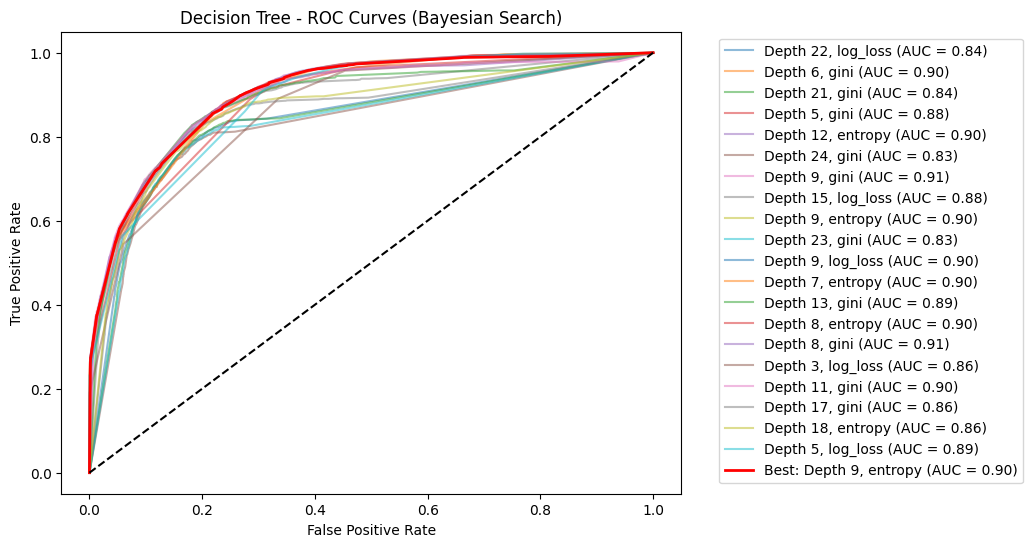

In [22]:
plt.figure(figsize=(8, 6))

all_models_dt = []
best_auc_dt = 0
best_fpr_dt, best_tpr_dt = None, None

for params in bayes_search_dt.cv_results_['params']:
    max_depth_dt = params['max_depth']
    criterion_dt = params['criterion']

    # Train model
    model_dt = DecisionTreeClassifier(max_depth=max_depth_dt, criterion=criterion_dt)
    model_dt.fit(X_train, y_train)

    # Predictions
    y_proba_dt = model_dt.predict_proba(X_test)[:, 1]

    # ROC Curve
    fpr_dt, tpr_dt, _ = roc_curve(y_test, y_proba_dt)
    roc_auc = auc(fpr_dt, tpr_dt)

    all_models_dt.append((max_depth_dt, criterion_dt, fpr_dt, tpr_dt, roc_auc))

    # Highlight the best model
    if (max_depth_dt == best_max_depth_dt) and (criterion_dt == best_criterion_dt):
        best_auc = roc_auc
        best_fpr, best_tpr = fpr_dt, tpr_dt

    plt.plot(fpr_dt, tpr_dt, label=f"Depth {max_depth_dt}, {criterion_dt} (AUC = {roc_auc:.2f})", alpha=0.5)

# Plot the best model
plt.plot(best_fpr, best_tpr, linewidth=2, label=f"Best: Depth {best_max_depth_dt}, {best_criterion_dt} (AUC = {best_auc:.2f})", color='red')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree - ROC Curves (Bayesian Search)')

# Move the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


In [23]:
# Train the best model separately
best_model_dt = DecisionTreeClassifier(max_depth=best_max_depth_dt, criterion=best_criterion_dt)
best_model_dt.fit(X_train, y_train)

# Predictions
y_pred_dt = best_model_dt.predict(X_test)
y_proba_dt = best_model_dt.predict_proba(X_test)[:, 1]

# Compute evaluation metrics
conf_matrix_decision_tree = confusion_matrix(y_test, y_pred_dt)
report_decision_tree = classification_report(y_test, y_pred_dt, output_dict=True)

# Specificity (True Negative Rate)
tn, fp, fn, tp = conf_matrix_decision_tree.ravel()
specificity = tn / (tn + fp)

# ROC Curve for best model
fpr, tpr, _ = roc_curve(y_test, y_proba_dt)
roc_auc = auc(fpr, tpr)

# Print Evaluation Results
print("\nDecision Tree Classification Report (Best Model):")
print(classification_report(y_test, y_pred_dt))
print(f"Specificity (True Negative Rate): {specificity:.4f}")


Decision Tree Classification Report (Best Model):
              precision    recall  f1-score   support

           0       0.88      0.95      0.91     11138
           1       0.77      0.58      0.67      3506

    accuracy                           0.86     14644
   macro avg       0.83      0.76      0.79     14644
weighted avg       0.85      0.86      0.85     14644

Specificity (True Negative Rate): 0.9460


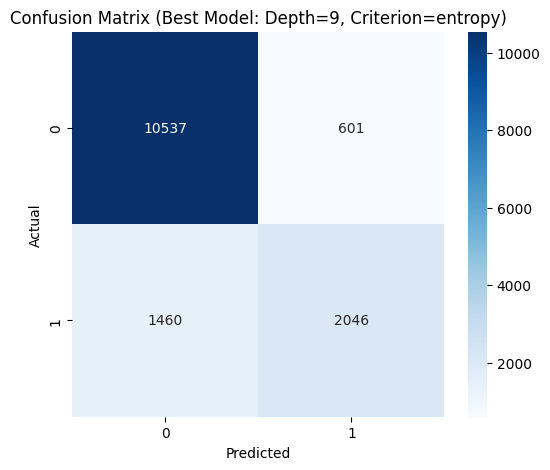

In [24]:
# Confusion Matrix Visualization
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_decision_tree, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix (Best Model: Depth={best_max_depth_dt}, Criterion={best_criterion_dt})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## **Ensemble Model: Random Forest**

- Build an ensemble of decision trees.
- Experiment with `n estimators`, `max features`, and `bootstrap`

In [152]:
# Define search space for Random Forest
search_space_rf = {
    'n_estimators': Integer(10, 500),  # Wider range
    'max_features': Categorical(['sqrt', 'log2', None, 0.1, 0.5]),
    'bootstrap': Categorical([True, False])
}

# Perform Bayesian Optimization
bayes_search_rf = BayesSearchCV(
    RandomForestClassifier(),
    search_space_rf,
    n_iter=10,  
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)
bayes_search_rf.fit(X_train, y_train)

# Get best parameters
best_params_rf = bayes_search_rf.best_params_
best_n_estimators = best_params_rf['n_estimators']
best_max_features = best_params_rf['max_features']
best_bootstrap = best_params_rf['bootstrap']

print(f"Best Parameters (Bayesian Search): n_estimators={best_n_estimators}, max_features={best_max_features}, bootstrap={best_bootstrap}")

Best Parameters (Bayesian Search): n_estimators=223, max_features=0.5, bootstrap=True


Model 0: n=223, max_features=0.5, boot=True, AUC=0.8892
Model 1: n=167, max_features=None, boot=True, AUC=0.8882
Model 2: n=230, max_features=log2, boot=True, AUC=0.8881
Model 3: n=273, max_features=log2, boot=False, AUC=0.8486
Model 4: n=426, max_features=sqrt, boot=False, AUC=0.8491
Model 5: n=93, max_features=0.5, boot=True, AUC=0.8879
Model 6: n=256, max_features=sqrt, boot=False, AUC=0.8501
Model 7: n=149, max_features=0.1, boot=False, AUC=0.8482
Model 8: n=403, max_features=0.5, boot=False, AUC=0.8521
Model 9: n=235, max_features=sqrt, boot=False, AUC=0.8501


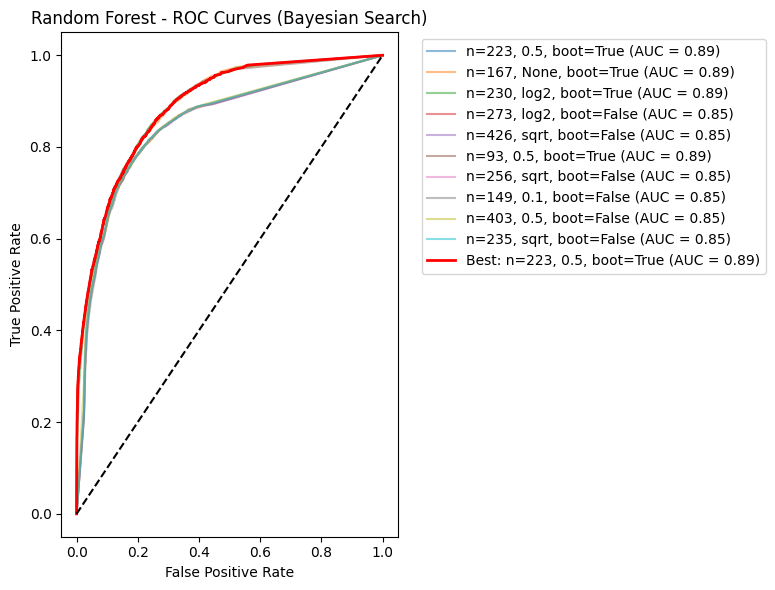

In [153]:
# Initialize plot
plt.figure(figsize=(8, 6))

all_models_rf = []
best_auc_rf = 0
best_fpr_rf, best_tpr_rf = None, None

for i, params in enumerate(bayes_search_rf.cv_results_['params']):
    n_estimators_rf = params['n_estimators']
    max_features_rf = params['max_features']
    bootstrap_rf = params['bootstrap']

    # Train model
    model_rf = RandomForestClassifier(n_estimators=n_estimators_rf, max_features=max_features_rf, bootstrap=bootstrap_rf)
    model_rf.fit(X_train, y_train)

    # Predictions
    y_proba_rf = model_rf.predict_proba(X_test)[:, 1]

    # ROC Curve
    fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
    roc_auc_rf = auc(fpr_rf, tpr_rf)

    all_models_rf.append((n_estimators_rf, max_features_rf, bootstrap_rf, fpr_rf, tpr_rf, roc_auc_rf))

    # Print to debug
    print(f"Model {i}: n={n_estimators_rf}, max_features={max_features_rf}, boot={bootstrap_rf}, AUC={roc_auc_rf:.4f}")

    # Plot with unique color for debugging
    plt.plot(fpr_rf, tpr_rf, label=f"n={n_estimators_rf}, {max_features_rf}, boot={bootstrap_rf} (AUC = {roc_auc_rf:.2f})", alpha=0.5)

    # Update best model variables if this is the best parameter set
    if (n_estimators_rf == best_n_estimators and 
        max_features_rf == best_max_features and 
        bootstrap_rf == best_bootstrap):
        best_auc_rf = roc_auc_rf
        best_fpr_rf = fpr_rf
        best_tpr_rf = tpr_rf

# Check if best_fpr_rf and best_tpr_rf are still None
if best_fpr_rf is None or best_tpr_rf is None:
    raise ValueError("Best model parameters were not found in the loop. Check bayes_search_rf.best_params_ and cv_results_['params'].")

# Plot the best model
plt.plot(best_fpr_rf, best_tpr_rf, linewidth=2, label=f"Best: n={best_n_estimators}, {best_max_features}, boot={best_bootstrap} (AUC = {best_auc_rf:.2f})", color='red')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest - ROC Curves (Bayesian Search)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [154]:
# Train the best model separately
best_model_rf = RandomForestClassifier(n_estimators=best_n_estimators, max_features=best_max_features, bootstrap=best_bootstrap)
best_model_rf.fit(X_train, y_train)

# Predictions
y_pred_rf = best_model_rf.predict(X_test)
y_proba_rf = best_model_rf.predict_proba(X_test)[:, 1]

# Compute evaluation metrics
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
report_rf = classification_report(y_test, y_pred_rf, output_dict=True)

# Specificity (True Negative Rate)
tn_rf, fp_rf, fn_rf, tp_rf = conf_matrix_rf.ravel()
specificity_rf = tn_rf / (tn_rf + fp_rf)

# ROC Curve for best model
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Print Evaluation Results
print("\nRandom Forest Classification Report (Best Model):")
print(classification_report(y_test, y_pred_rf))
print(f"Specificity (True Negative Rate): {specificity_rf:.4f}")


Random Forest Classification Report (Best Model):
              precision    recall  f1-score   support

           0       0.89      0.91      0.90     11138
           1       0.70      0.63      0.66      3506

    accuracy                           0.85     14644
   macro avg       0.79      0.77      0.78     14644
weighted avg       0.84      0.85      0.84     14644

Specificity (True Negative Rate): 0.9143


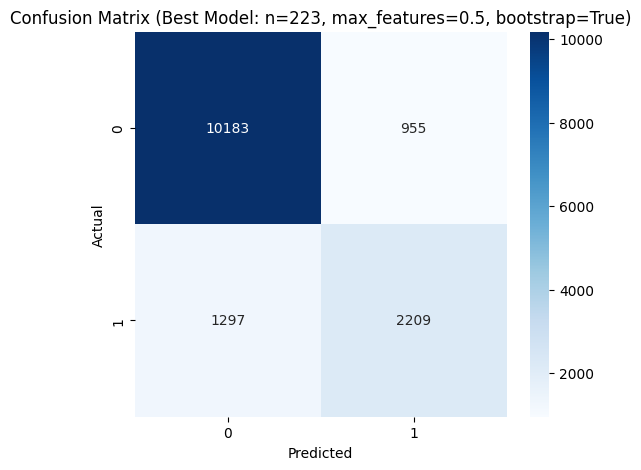

In [155]:
# Confusion Matrix Visualization
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix (Best Model: n={best_n_estimators}, max_features={best_max_features}, bootstrap={best_bootstrap})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## **Naive Bayes**

- Implement *Gaussian Naive Bayes* (or any other variants like *Bernoulli* or *Multinomial* if applicable to the dataset).
- Experiment with `var_smoothing` for *Gaussian* Naive Bayes or `alpha` for *Bernoulli* or *Multinomial Naive Bayes*

**Gaussian Naive Bayes**

In [156]:
# Separate numerical and binary features
num_features = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
binary_features = [col for col in X.columns if col not in num_features and col != 'income']

X_num = X[num_features]  # Continuous features
X_bin = X[binary_features]  # Binary features


In [157]:
# Define search space for Gaussian Naïve Bayes
search_space_gnb = {'var_smoothing': Real(1e-9, 1e-3, prior='log-uniform')}

# Perform Bayesian Optimization
bayes_search_gnb = BayesSearchCV(
    GaussianNB(),
    search_space_gnb,
    n_iter=10,  
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)

bayes_search_gnb.fit(X_train[num_features], y_train)  # Train using numerical features

# Get best parameters
best_var_smoothing = bayes_search_gnb.best_params_['var_smoothing']

print(f"Best Parameters (Bayesian Search - Gaussian NB): var_smoothing={best_var_smoothing:.1e}")

Best Parameters (Bayesian Search - Gaussian NB): var_smoothing=2.3e-04


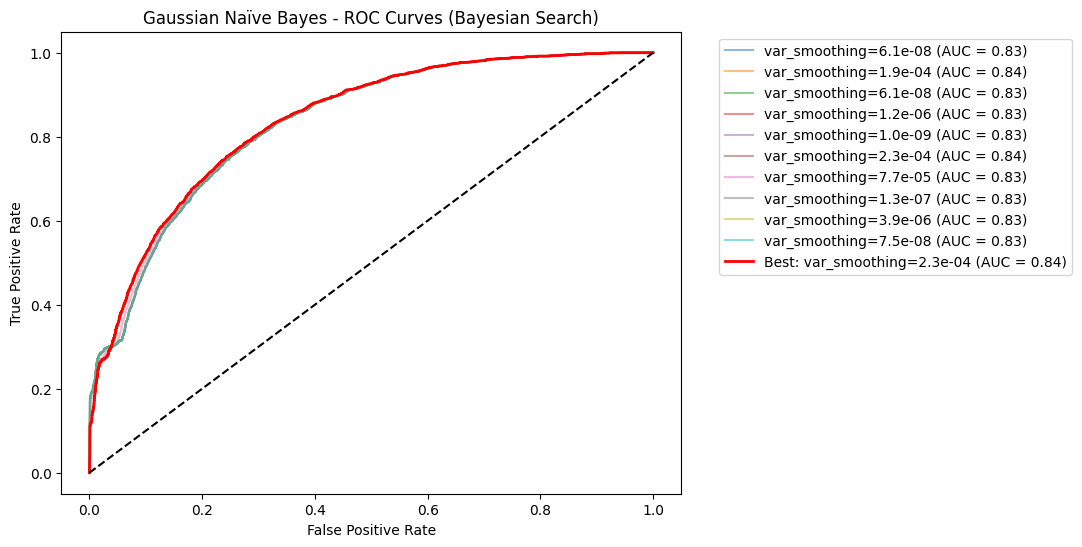

In [158]:
# Initialize plot
plt.figure(figsize=(8, 6))

all_models_gnb = []
best_auc_gnb = 0
best_fpr_gnb, best_tpr_gnb = None, None

for params in bayes_search_gnb.cv_results_['params']:
    var_smoothing_gnb = params['var_smoothing']

    # Train model
    model_gnb = GaussianNB(var_smoothing=var_smoothing_gnb)
    model_gnb.fit(X_train[num_features], y_train)

    # Predictions
    y_proba_gnb = model_gnb.predict_proba(X_test[num_features])[:, 1]

    # ROC Curve
    fpr_gnb, tpr_gnb, _ = roc_curve(y_test, y_proba_gnb)
    roc_auc_gnb = auc(fpr_gnb, tpr_gnb)

    all_models_gnb.append((var_smoothing_gnb, fpr_gnb, tpr_gnb, roc_auc_gnb))

    # Highlight the best model
    if var_smoothing_gnb == best_var_smoothing:
        best_auc_gnb = roc_auc_gnb
        best_fpr_gnb, best_tpr_gnb = fpr_gnb, tpr_gnb

    plt.plot(fpr_gnb, tpr_gnb, label=f"var_smoothing={var_smoothing_gnb:.1e} (AUC = {roc_auc_gnb:.2f})", alpha=0.5)

# Plot the best model
plt.plot(best_fpr_gnb, best_tpr_gnb, linewidth=2, label=f"Best: var_smoothing={best_var_smoothing:.1e} (AUC = {best_auc_gnb:.2f})", color='red')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Gaussian Naïve Bayes - ROC Curves (Bayesian Search)')

# Move the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


In [159]:
# Train the best model separately
best_gnb = GaussianNB(var_smoothing=best_var_smoothing)
best_gnb.fit(X_train[num_features], y_train)

# Predictions
y_pred_gnb = best_gnb.predict(X_test[num_features])
y_proba_gnb = best_gnb.predict_proba(X_test[num_features])[:, 1]

# Compute evaluation metrics
conf_matrix_gnb = confusion_matrix(y_test, y_pred_gnb)
report_gnb = classification_report(y_test, y_pred_gnb, output_dict=True)

# Specificity (True Negative Rate)
tn_gnb, fp_gnb, fn_gnb, tp_gnb = conf_matrix_gnb.ravel()
specificity_gnb = tn_gnb / (tn_gnb + fp_gnb)

# ROC Curve for best model
fpr_gnb, tpr_gnb, _ = roc_curve(y_test, y_proba_gnb)
roc_auc_gnb = auc(fpr_gnb, tpr_gnb)

# Print Evaluation Results
print("\nGaussian Naïve Bayes Classification Report (Best Model):")
print(classification_report(y_test, y_pred_gnb))
print(f"Specificity (True Negative Rate): {specificity_gnb:.4f}")


Gaussian Naïve Bayes Classification Report (Best Model):
              precision    recall  f1-score   support

           0       0.81      0.97      0.88     11138
           1       0.73      0.29      0.41      3506

    accuracy                           0.80     14644
   macro avg       0.77      0.63      0.65     14644
weighted avg       0.79      0.80      0.77     14644

Specificity (True Negative Rate): 0.9658


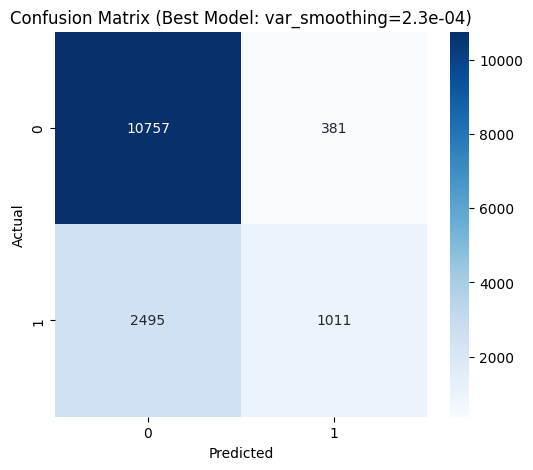

In [160]:
# Confusion Matrix Visualization
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_gnb, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix (Best Model: var_smoothing={best_var_smoothing:.1e})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

**Bernoulli Naive Bayes**

In [ ]:
# Define search space for Bernoulli Naïve Bayes
search_space_bnb = {'alpha': Real(0.01, 10, prior='log-uniform')}

# Perform Bayesian Optimization
bayes_search_bnb = BayesSearchCV(
    BernoulliNB(),
    search_space_bnb,
    n_iter=10,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)

bayes_search_bnb.fit(X_train[binary_features], y_train)  # Train using binary features

# Get best parameters
best_alpha_bnb = bayes_search_bnb.best_params_['alpha']

print(f"Best Parameters (Bayesian Search - Bernoulli NB): alpha={best_alpha_bnb:.2f}")

Best Parameters (Bayesian Search - Bernoulli NB): alpha=0.66


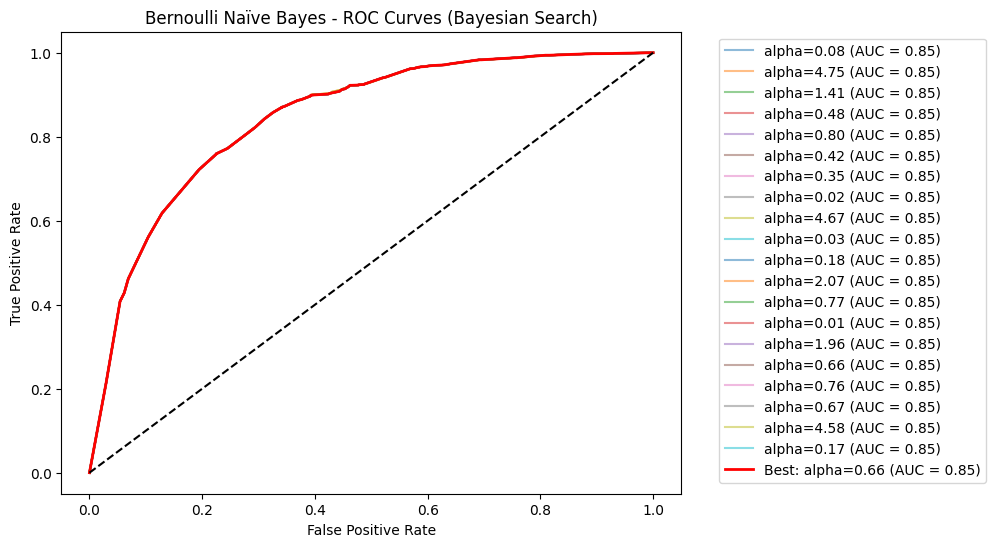

In [162]:
plt.figure(figsize=(8, 6))

all_models_bnb = []
best_auc_bnb = 0
best_fpr_bnb, best_tpr_bnb = None, None

for params in bayes_search_bnb.cv_results_['params']:
    alpha_bnb = params['alpha']

    # Train model
    model_bnb = BernoulliNB(alpha=alpha_bnb)
    model_bnb.fit(X_train[binary_features], y_train)

    # Predictions
    y_proba_bnb = model_bnb.predict_proba(X_test[binary_features])[:, 1]

    # ROC Curve
    fpr_bnb, tpr_bnb, _ = roc_curve(y_test, y_proba_bnb)
    roc_auc_bnb = auc(fpr_bnb, tpr_bnb)

    all_models_bnb.append((alpha_bnb, fpr_bnb, tpr_bnb, roc_auc_bnb))

    # Highlight the best model
    if alpha_bnb == best_alpha_bnb:
        best_auc_bnb = roc_auc_bnb
        best_fpr_bnb, best_tpr_bnb = fpr_bnb, tpr_bnb

    plt.plot(fpr_bnb, tpr_bnb, label=f"alpha={alpha_bnb:.2f} (AUC = {roc_auc_bnb:.2f})", alpha=0.5)

# Plot the best model
plt.plot(best_fpr_bnb, best_tpr_bnb, linewidth=2, label=f"Best: alpha={best_alpha_bnb:.2f} (AUC = {best_auc_bnb:.2f})", color='red')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Bernoulli Naïve Bayes - ROC Curves (Bayesian Search)')

# Move the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [163]:
# Train the best model separately
best_bnb = BernoulliNB(alpha=best_alpha_bnb)
best_bnb.fit(X_train[binary_features], y_train)

# Predictions
y_pred_bnb = best_bnb.predict(X_test[binary_features])
y_proba_bnb = best_bnb.predict_proba(X_test[binary_features])[:, 1]

# Compute evaluation metrics
conf_matrix_bnb = confusion_matrix(y_test, y_pred_bnb)
report_bnb = classification_report(y_test, y_pred_bnb, output_dict=True)

# Specificity (True Negative Rate)
tn_bnb, fp_bnb, fn_bnb, tp_bnb = conf_matrix_bnb.ravel()
specificity_bnb = tn_bnb / (tn_bnb + fp_bnb)

# ROC Curve for best model
fpr_bnb, tpr_bnb, _ = roc_curve(y_test, y_proba_bnb)
roc_auc_bnb = auc(fpr_bnb, tpr_bnb)

# Print Evaluation Results
print("\nBernoulli Naïve Bayes Classification Report (Best Model):")
print(classification_report(y_test, y_pred_bnb))
print(f"Specificity (True Negative Rate): {specificity_bnb:.4f}")


Bernoulli Naïve Bayes Classification Report (Best Model):
              precision    recall  f1-score   support

           0       0.91      0.78      0.84     11138
           1       0.52      0.76      0.61      3506

    accuracy                           0.77     14644
   macro avg       0.71      0.77      0.73     14644
weighted avg       0.82      0.77      0.78     14644

Specificity (True Negative Rate): 0.7752


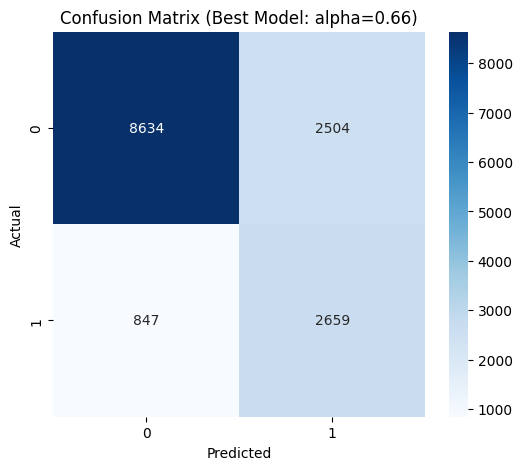

In [164]:
# Confusion Matrix Visualization
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_bnb, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix (Best Model: alpha={best_alpha_bnb:.2f})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## **Support Vector Machine (SVM)**

In [167]:
# Define a reduced search space for SVM
search_space_svm = {
    'C': Real(0.1, 10, prior='log-uniform'),  # Narrower range for regularization
    'gamma': Real(1e-2, 0.1, prior='log-uniform'),  # Narrower range for gamma
    'kernel': Categorical(['linear', 'poly', 'sigmoid'])  # Limit to two common kernels
}

# Perform Bayesian Optimization with fewer iterations and folds
bayes_search_svm = BayesSearchCV(
    SVC(probability=True),  
    search_space_svm,
    n_iter=5, 
    scoring='roc_auc',
    cv=3,  
    n_jobs=-1, 
    random_state=42  
)

# Fit the model
bayes_search_svm.fit(X_train, y_train)

# Get best parameters
best_params_svm = bayes_search_svm.best_params_
best_C_svm = best_params_svm['C']
best_gamma_svm = best_params_svm['gamma']
best_kernel_svm = best_params_svm['kernel']

print(f"Best Parameters (SVM Bayesian Search): C={best_C_svm:.2f}, gamma={best_gamma_svm:.5f}, kernel={best_kernel_svm}")

Best Parameters (SVM Bayesian Search): C=4.73, gamma=0.07644, kernel=linear


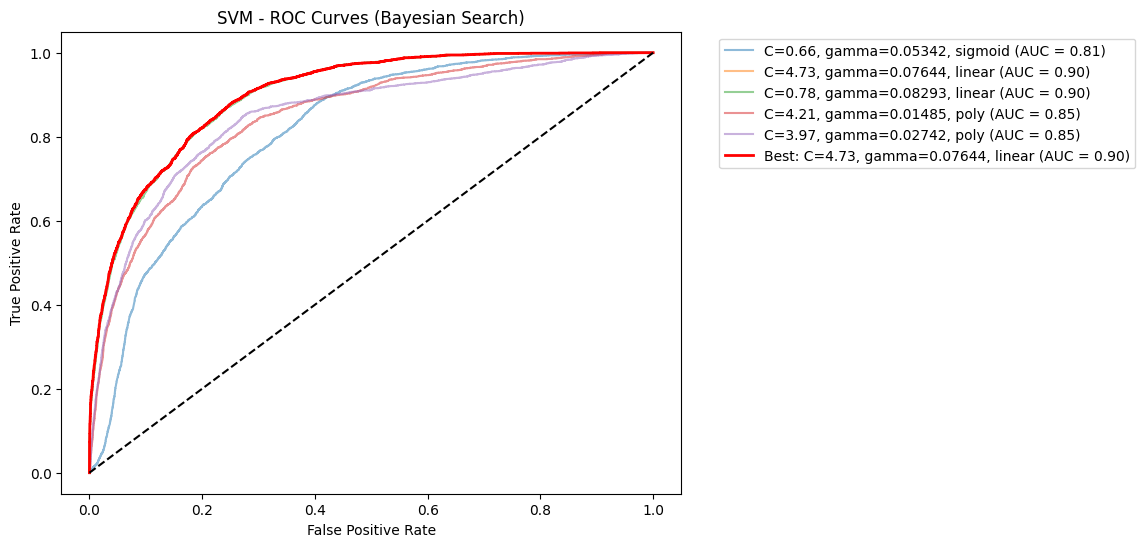

In [168]:
plt.figure(figsize=(8, 6))

all_models_svm = []
best_auc_svm = 0
best_fpr_svm, best_tpr_svm = None, None

for params in bayes_search_svm.cv_results_['params']:
    C_svm = params['C']
    gamma_svm = params['gamma']
    kernel_svm = params['kernel']

    # Train model
    model_svm = SVC(C=C_svm, gamma=gamma_svm, kernel=kernel_svm, probability=True)
    model_svm.fit(X_train, y_train)

    # Predictions
    y_proba_svm = model_svm.predict_proba(X_test)[:, 1]

    # ROC Curve
    fpr_svm, tpr_svm, _ = roc_curve(y_test, y_proba_svm)
    roc_auc_svm = auc(fpr_svm, tpr_svm)

    all_models_svm.append((C_svm, gamma_svm, kernel_svm, fpr_svm, tpr_svm, roc_auc_svm))

    # Highlight the best model
    if (C_svm == best_C_svm) and (gamma_svm == best_gamma_svm) and (kernel_svm == best_kernel_svm):
        best_auc_svm = roc_auc_svm
        best_fpr_svm, best_tpr_svm = fpr_svm, tpr_svm

    plt.plot(fpr_svm, tpr_svm, label=f"C={C_svm:.2f}, gamma={gamma_svm:.5f}, {kernel_svm} (AUC = {roc_auc_svm:.2f})", alpha=0.5)

# Plot the best model
plt.plot(best_fpr_svm, best_tpr_svm, linewidth=2, label=f"Best: C={best_C_svm:.2f}, gamma={best_gamma_svm:.5f}, {best_kernel_svm} (AUC = {best_auc_svm:.2f})", color='red')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM - ROC Curves (Bayesian Search)')

# Move the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [169]:
# Train the best model separately
best_model_svm = SVC(C=best_C_svm, gamma=best_gamma_svm, kernel=best_kernel_svm, probability=True)
best_model_svm.fit(X_train, y_train)

# Predictions
y_pred_svm = best_model_svm.predict(X_test)
y_proba_svm = best_model_svm.predict_proba(X_test)[:, 1]

# Compute evaluation metrics
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
report_svm = classification_report(y_test, y_pred_svm, output_dict=True)

# Specificity (True Negative Rate)
tn_svm, fp_svm, fn_svm, tp_svm = conf_matrix_svm.ravel()
specificity_svm = tn_svm / (tn_svm + fp_svm)

# ROC Curve for best model
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_proba_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

# Print Evaluation Results
print("\nSVM Classification Report (Best Model):")
print(classification_report(y_test, y_pred_svm))
print(f"Specificity (True Negative Rate): {specificity_svm:.4f}")


SVM Classification Report (Best Model):
              precision    recall  f1-score   support

           0       0.88      0.93      0.91     11138
           1       0.73      0.60      0.66      3506

    accuracy                           0.85     14644
   macro avg       0.81      0.77      0.78     14644
weighted avg       0.85      0.85      0.85     14644

Specificity (True Negative Rate): 0.9316


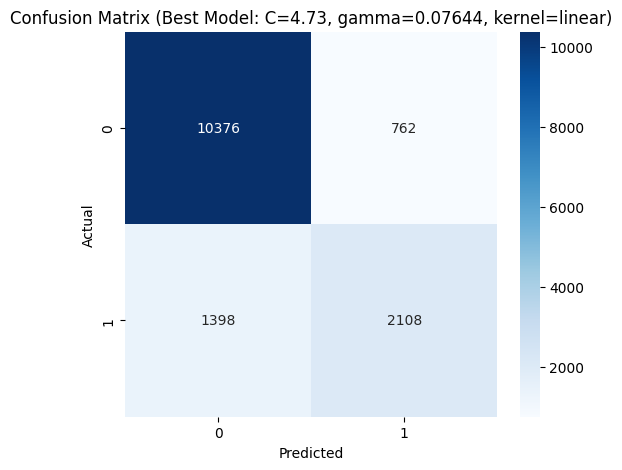

In [170]:
# Confusion Matrix Visualization
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix (Best Model: C={best_C_svm:.2f}, gamma={best_gamma_svm:.5f}, kernel={best_kernel_svm})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## **Neural Network: Multilayer Perceptron (MLP)**

In [ ]:
# Define search space for MLP (as a parameter grid)
param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (100, 100), (100, 100, 100)],  # Tuple options
    'activation': ['relu', 'tanh', 'logistic'],  # Valid activation functions
    'learning_rate_init': [1e-4, 1e-3, 1e-2, 1e-1],  # Discrete values instead of continuous range
    'max_iter': [100, 150],  # Discrete values
}

# Initialize MLPClassifier
mlp = MLPClassifier(solver='adam', random_state=42)

# Perform Grid Search
grid_search_mlp = GridSearchCV(
    estimator=mlp,
    param_grid=param_grid_mlp,
    scoring='roc_auc',  # ROC AUC for binary classification
    cv=3,  # 5-fold cross-validation
    n_jobs=-1,  # Use all available cores
)

# Fit the model
grid_search_mlp.fit(X_train, y_train)

# Get best parameters
best_params_mlp = grid_search_mlp.best_params_
best_hidden_layer_sizes = best_params_mlp['hidden_layer_sizes']
best_activation = best_params_mlp['activation']
best_learning_rate = best_params_mlp['learning_rate_init']

# Print results
print(f"Best Parameters (MLP Grid Search): hidden_layer_sizes={best_hidden_layer_sizes}, "
      f"activation={best_activation}, learning_rate={best_learning_rate:.5f}")

In [ ]:
plt.figure(figsize=(8, 6))

all_models_mlp = []
best_auc_mlp = 0
best_fpr_mlp, best_tpr_mlp = None, None

for params in bayes_search_mlp.cv_results_['params']:
    hidden_layer_sizes_mlp = params['hidden_layer_sizes']
    activation_mlp = params['activation']
    learning_rate_mlp = params['learning_rate_init']

    # Train model
    model_mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes_mlp, 
                              activation=activation_mlp, 
                              learning_rate_init=learning_rate_mlp, 
                              solver='adam', random_state=42)
    model_mlp.fit(X_train, y_train)

    # Predictions
    y_proba_mlp = model_mlp.predict_proba(X_test)[:, 1]

    # ROC Curve
    fpr_mlp, tpr_mlp, _ = roc_curve(y_test, y_proba_mlp)
    roc_auc_mlp = auc(fpr_mlp, tpr_mlp)

    all_models_mlp.append((hidden_layer_sizes_mlp, activation_mlp, learning_rate_mlp, fpr_mlp, tpr_mlp, roc_auc_mlp))

    # Highlight the best model
    if (hidden_layer_sizes_mlp == best_hidden_layer_sizes) and (activation_mlp == best_activation) and (learning_rate_mlp == best_learning_rate):
        best_auc_mlp = roc_auc_mlp
        best_fpr_mlp, best_tpr_mlp = fpr_mlp, tpr_mlp

    plt.plot(fpr_mlp, tpr_mlp, label=f"Layers {hidden_layer_sizes_mlp}, {activation_mlp}, lr={learning_rate_mlp:.5f} (AUC = {roc_auc_mlp:.2f})", alpha=0.5)

# Plot the best model
plt.plot(best_fpr_mlp, best_tpr_mlp, linewidth=2, label=f"Best: Layers {best_hidden_layer_sizes}, {best_activation}, lr={best_learning_rate:.5f} (AUC = {best_auc_mlp:.2f})", color='red')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('MLP - ROC Curves (Bayesian Search)')

# Move the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [ ]:
# Confusion Matrix Visualization
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_mlp, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix (Best Model: Layers={best_hidden_layer_sizes}, Activation={best_activation})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## **Evaluation Summary**

In [ ]:
# Collecting metrics for each model
metrics_dict = {
    'Model': ['Decision Tree', 'Random Forest', 'Gaussian Naïve Bayes', 'Bernoulli Naïve Bayes'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_dt),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_gnb),
        accuracy_score(y_test, y_pred_bnb)
    ],
    'Precision': [
        precision_score(y_test, y_pred_dt),
        precision_score(y_test, y_pred_rf),
        precision_score(y_test, y_pred_gnb),
        precision_score(y_test, y_pred_bnb)
    ],
    'Recall': [
        recall_score(y_test, y_pred_dt),
        recall_score(y_test, y_pred_rf),
        recall_score(y_test, y_pred_gnb),
        recall_score(y_test, y_pred_bnb)
    ],
    'Specificity': [
        specificity, specificity_rf, specificity_gnb, specificity_bnb
    ],
    'F1 Score': [
        f1_score(y_test, y_pred_dt),
        f1_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_gnb),
        f1_score(y_test, y_pred_bnb)
    ],
    'AUC': [
        roc_auc_score(y_test, y_proba_dt),
        roc_auc_score(y_test, y_proba_rf),
        roc_auc_score(y_test, y_proba_gnb),
        roc_auc_score(y_test, y_proba_bnb)
    ]
}

# Creating a DataFrame to display the metrics
metrics_df = pd.DataFrame(metrics_dict)

# Print the evaluation metrics table
print("Evaluation Metrics Comparison:")
print(metrics_df)

# Plot the comparison of evaluation metrics
metrics_df.set_index('Model').plot(kind='bar', figsize=(10, 6), colormap='viridis')
plt.title('Comparison of Evaluation Metrics for Different Models')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()